In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from functools import partial

### Import MNIST data

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()    

In [3]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


### set parameters

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
learning_rate = 0.01
l2_reg = 0.0001

training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 28 * 28
n_hidden_1 = 256
n_hidden_2 = 128


# log directory for tensorboard
log_dir = '/tmp/tensorflow/autoencoder/logs/summaries'

In [6]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。

In [7]:
he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 

dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

### tensorboardへの表示用にラッパー関数を作成

In [8]:
def nn_layer(input_tensor, output_dim, name):
    with tf.variable_scope(name):
        layer = dense_layer(input_tensor, output_dim)
        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

### decoder部

In [9]:
def encoder(x):
    #layer_1 = dense_layer(x, n_hidden_1, name='encoder_1')
    #layer_2 = dense_layer(layer_1, n_hidden_2, name='encoder_2')
    layer_1 = nn_layer(x, n_hidden_1, name='encoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_2, name='encoder_2')
    return layer_2

### encoder部

In [10]:
def decoder(x):
    #layer_1 = dense_layer(x, n_hidden_1, name='decoder_1')
    #layer_2 = dense_layer(layer_1, n_input, name='decoder_2')
    layer_1 = nn_layer(x, n_hidden_1, name='decoder_1')
    layer_2 = nn_layer(layer_1, n_input, name='decoder_2')
    return layer_2

In [11]:
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = decoder_op

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


Epoch: 0001 cost= 0.037185010
Epoch: 0002 cost= 0.030499917
Epoch: 0003 cost= 0.019145034
Epoch: 0004 cost= 0.017047802
Epoch: 0005 cost= 0.015766976
Epoch: 0006 cost= 0.013069213
Epoch: 0007 cost= 0.014825644
Epoch: 0008 cost= 0.012849431
Epoch: 0009 cost= 0.011420570
Epoch: 0010 cost= 0.013760529
Optimization Finished!


/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


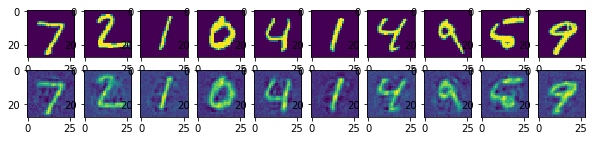

In [15]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')

    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))

        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()

    # Applying encode and decode over test set
    encode_decode = sess.run(y_pred,
                             feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()

sess.close()